# Magic feature 1

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from collections import defaultdict

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

In [5]:
train_orig =  pd.read_csv('../input/train.csv', header=0)
test_orig =  pd.read_csv('../input/test.csv', header=0)

In [5]:
ques = pd.concat([train_orig[['question1', 'question2']], \
        test_orig[['question1', 'question2']]], axis=0).reset_index(drop='index')
ques.shape

(2750086, 2)

In [6]:
q_dict = defaultdict(set)
for i in range(ques.shape[0]):
        q_dict[ques.question1[i]].add(ques.question2[i])
        q_dict[ques.question2[i]].add(ques.question1[i])

In [5]:
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

In [6]:
train_orig['q1_q2_intersect'] = train_orig.apply(q1_q2_intersect, axis=1, raw=True)
test_orig['q1_q2_intersect'] = test_orig.apply(q1_q2_intersect, axis=1, raw=True)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


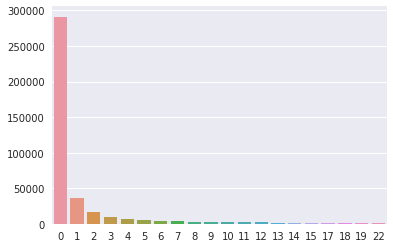

In [8]:
temp = train_orig.q1_q2_intersect.value_counts()
sns.barplot(temp.index[:20], temp.values[:20])

In [9]:
train_feat = train_orig[['q1_q2_intersect']]
test_feat = test_orig[['q1_q2_intersect']]

In [20]:
train_feat = pd.read_csv('../features/train_magic_feature_v2.csv')[['index', 'q1_q2_intersect']]
test_feat = pd.read_csv('../features/test_magic_feature_v2.csv')[['index', 'q1_q2_intersect']]

In [18]:
train_feat = train_feat.reset_index()
test_feat = test_feat.reset_index()

In [ ]:
train_feat = train_feat.columns = []
test_feat = test_feat.reset_index()

In [21]:
train_feat.head()

,index,q1_q2_intersect
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [17]:
train_feat.to_csv('../features/train_magic_feature_v2.csv')
test_feat.to_csv('../features/test_magic_feature_v2.csv')

In [13]:
print(train_feat.shape, test_feat.shape)

(404290, 2) (2345796, 2)


# Magic feature 2

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np
import pandas as pd
import timeit

In [ ]:
train_orig =  pd.read_csv('../input/train.csv', header=0)
test_orig =  pd.read_csv('../input/test.csv', header=0)

tic0=timeit.default_timer()
df1 = train_orig[['question1']].copy()
df2 = train_orig[['question2']].copy()
df1_test = test_orig[['question1']].copy()
df2_test = test_orig[['question2']].copy()

df2.rename(columns = {'question2':'question1'},inplace=True)
df2_test.rename(columns = {'question2':'question1'},inplace=True)

train_questions = df1.append(df2)
train_questions = train_questions.append(df1_test)
train_questions = train_questions.append(df2_test)
#train_questions.drop_duplicates(subset = ['qid1'],inplace=True)
train_questions.drop_duplicates(subset = ['question1'],inplace=True)

train_questions.reset_index(inplace=True,drop=True)
questions_dict = pd.Series(train_questions.index.values,index=train_questions.question1.values).to_dict()
train_cp = train_orig.copy()
test_cp = test_orig.copy()
train_cp.drop(['qid1','qid2'],axis=1,inplace=True)

test_cp['is_duplicate'] = -1
test_cp.rename(columns={'test_id':'id'},inplace=True)
comb = pd.concat([train_cp,test_cp])

comb['q1_hash'] = comb['question1'].map(questions_dict)
comb['q2_hash'] = comb['question2'].map(questions_dict)

q1_vc = comb.q1_hash.value_counts().to_dict()
q2_vc = comb.q2_hash.value_counts().to_dict()

def try_apply_dict(x,dict_to_apply):
    try:
        return dict_to_apply[x]
    except KeyError:
        return 0
#map to frequency space
comb['q1_freq'] = comb['q1_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))
comb['q2_freq'] = comb['q2_hash'].map(lambda x: try_apply_dict(x,q1_vc) + try_apply_dict(x,q2_vc))

train_comb = comb[comb['is_duplicate'] >= 0][['id','q1_hash','q2_hash','q1_freq','q2_freq','is_duplicate']]
test_comb = comb[comb['is_duplicate'] < 0][['id','q1_hash','q2_hash','q1_freq','q2_freq']]

In [ ]:
corr_mat = train_comb.corr()
corr_mat.head()
#more frequenct questions are more likely to be duplicates

In [ ]:
comb.head()

In [ ]:
train_size = 404290

train_magic_feat = comb[:train_size]
test_magic_feat = comb[train_size:]

In [ ]:
print(train_magic_feat.shape, test_magic_feat.shape)

In [ ]:
train_magic_feat.to_csv('../features/train_magic_feature_v1.csv')
test_magic_feat.to_csv('../features/test_magic_feature_v1.csv')

# Magic feature 3

In [6]:
ques = pd.concat([train_orig[['question1', 'question2']], \
        test_orig[['question1', 'question2']]], axis=0).reset_index(drop='index')
ques.shape

(2750086, 2)

In [7]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))
def word_match_share(q1, q2, stops=None):
    q1 = str(q1).lower().split()
    q2 = str(q2).lower().split()
    q1words = {}
    q2words = {}
    for word in q1:
        if word not in stops:
            q1words[word] = 1
    for word in q2:
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0.
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

In [8]:
q_dict = defaultdict(dict)
for i in range(ques.shape[0]):
        wm = word_match_share(ques.question1[i], ques.question2[i], stops=stops)
        q_dict[ques.question1[i]][ques.question2[i]] = wm
        q_dict[ques.question2[i]][ques.question1[i]] = wm

In [9]:
def q1_q2_intersect(row):
    return(len(set(q_dict[row['question1']]).intersection(set(q_dict[row['question2']]))))

def q1_q2_wm_ratio(row):
    q1 = q_dict[row['question1']]
    q2 = q_dict[row['question2']]
    inter_keys = set(q1.keys()).intersection(set(q2.keys()))
    if(len(inter_keys) == 0): return 0.
    inter_wm = 0.
    total_wm = 0.
    for q,wm in q1.items():
        if q in inter_keys:
            inter_wm += wm
        total_wm += wm
    for q,wm in q2.items():
        if q in inter_keys:
            inter_wm += wm
        total_wm += wm
    if(total_wm == 0.): return 0.
    return inter_wm/total_wm

In [ ]:
train_orig['q1_q2_wm_ratio'] = train_orig.apply(q1_q2_wm_ratio, axis=1, raw=True)
test_orig['q1_q2_wm_ratio'] = test_orig.apply(q1_q2_wm_ratio, axis=1, raw=True)

In [ ]:
train_orig.to_csv('../features/train_magic_feature_v3.csv')
test_orig.to_csv('../features/test_magic_feature_v3.csv')